# Example Notebook

Installation:

```python
tensorflow-gpu
sklearn
matplotlib
numpy
pandas
tqdm
gpflow
shapely (not really needed but it's in src.util)
```

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [34]:
import sys 
sys.path.append("../..")
import numpy as np 
from sklearn.cluster import KMeans
import gpflow 
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler#
import matplotlib.pyplot as plt


from src.bagData import BagData, create_tensorflow_iterator, create_bag_sameresolution_dictionary
from src.svgp import VBagg
from src.util import optimize_adam, optimize_natgrad_adam, save_model, load_model


In [19]:
# read the example datasets
df_features = pd.read_csv("example_features.csv")
df_response = pd.read_csv("example_response.csv")

In [20]:
# write down what the names of the columns are called
dates = ['04-07']
features = ["key", "County", "State", "year", "longitude", "latitude"] + [f"EVI_{date}" for date in dates] + [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]

In [21]:
# collect the feature columns. In this dataset, we have features SPACE, MODIS, PR, TMMX
latlon_cols = ["longitude", "latitude"]
modis_cols = [f"EVI_{date}" for date in dates]
pr_cols = [f"pr_{date}" for date in dates] 
tmmx_cols = [f"tmmx_{date}" for date in dates] 
all_features = latlon_cols + modis_cols + pr_cols + tmmx_cols

# collect the index of the features
col_index_space = [0, 1]
col_index_modis = [2]
col_index_pr = [3]
col_index_tmmx = [4]
col_index_all = col_index_space + col_index_modis + col_index_pr + col_index_tmmx

In [22]:
# the keys here store the county names 
keys = list(set(df_response.key))
keys.sort()
print("Example of a key following COUNTY-STATE format:", keys[0])

Example of a key following COUNTY-STATE format: ADAIR-IOWA


In [23]:
len(keys), 384/5

(384, 76.8)

In [24]:
# Since this is an example, we use 20 training bags and 10 test bags
# we randomly split the data into 80% train, 20% test
test_keys = np.arange(0, 10)
train_keys = np.arange(10, 30)
print(len(test_keys), len(train_keys))

10 20


In [25]:
iterations = 500 # set it to 20000 when actually training
num_minibatch = 50
lr_adam = 0.001
# maximum length of tensor (TensorFlow assumes static tensors i.e. tensors in the computational graph are fixed sizes). If a set only has 51 observations, then observations 52,53,...,99 are set to 0
# In this case, the maximum number of observations in each set is 100, so we set it to this
max_pixels = 100 

In [26]:
train_keys = [keys[key] for key in train_keys]
test_keys = [keys[key] for key in test_keys]
X_train = df_features.loc[(df_features["key"].isin(train_keys)), all_features].values
X_test = df_features.loc[(df_features["key"].isin(test_keys)), all_features].values
y_train = df_response[(df_response["key"].isin(train_keys))].y.values[:, None]
y_test = df_response[(df_response["key"].isin(test_keys))].y.values[:, None]

# optional feature engineering step
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train, y_train = scaler_x.transform(X_train), scaler_y.transform(y_train)
X_test = scaler_x.transform(X_test)

# this creates a dictionary storing the data and set-item weights
train_dict = create_bag_sameresolution_dictionary(
    X_train, 
    y_train, 
    df_features[(df_features["key"].isin(train_keys))],
    df_response[(df_response["key"].isin(train_keys))],
    train_keys,
    max_pixels
)
test_dict = create_bag_sameresolution_dictionary(
    X_test, 
    y_test, 
    df_features[(df_features["key"].isin(test_keys))],
    df_response[(df_response["key"].isin(test_keys))],
    test_keys,
    max_pixels
)
output_types=(
    tf.int64, 
    tf.float64, 
    tf.float64, 
    tf.float64
)

# these 2 objects store the dictionaries and help generate the sets so that it can be handled using a 
# TensorFlow iterator
train_bags = BagData(bag_data=train_dict, bags_metadata="train")
test_bags = BagData(bag_data=test_dict, bags_metadata="test")

ds_train = create_tensorflow_iterator(train_bags.gen_bags, output_types=output_types)

100%|██████████| 10/10 [00:00<00:00, 2994.43it/s]


In [27]:
# See Zhu et al. (2022) for an explanation. The variational posterior approximation is done using SVGP
# create inducing points
kmeans = KMeans(1)
Z = np.zeros((train_bags.num_bags, len(col_index_all)))
for i, bag in enumerate(train_bags.bags):
    data = train_bags[bag]
    Z_tmp = kmeans.fit(data[2]).cluster_centers_
    Z[i] = Z_tmp

# specify which dimensions of the input features the kernel acts on
# If you want to use a Conv1D in the kernel, you need to rewrite the kernel
k = gpflow.kernels.RBF(active_dims=col_index_all)
m = VBagg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z,num_data=train_bags.num_bags)

# Fix the inducing points Z and don't train them
gpflow.set_trainable(m.inducing_variable, False)



In [33]:
# fit and train GP regression model
print("Begin Training")
# using natural gradients on the variational parameters, and Adam for other hyperparameters
# alternatively, use Adam optimize_adam(). 
logf = optimize_natgrad_adam(m, ds_train, num_data=train_bags.num_bags, iterations=iterations, minibatch_size=num_minibatch, learning_rate=lr_adam)

# for model saving
save_model(m, save_path="./", model_name=f"VBagg_example")

Begin Training


EPOCH: 0, ELBO: -25.673313263234746: 100%|██████████| 500/500 [00:16<00:00, 29.95it/s]


In [35]:
# make predictions
y_pred = np.zeros(test_bags.num_bags)
y_std = np.zeros(test_bags.num_bags)

for i, bag in enumerate(test_bags.bags):
    f_mean, f_var = m.predict_aggregated(test_bags[bag][1], test_bags[bag][2])
    y_pred[i] = f_mean[0][0]
    y_std[i] = np.sqrt(f_var[0][0])
    
loglik = np.mean(m.predict_log_density(y_pred[:, None], y_std[:, None]**2, scaler_y.transform(test_bags.y)))
y_pred_rescaled = scaler_y.inverse_transform(y_pred[:, None])

In [36]:
# calculate 95% credible intervals
lower = np.reshape((1.96 * y_std)*scaler_y.scale_, y_test.shape)
upper = np.reshape((1.96 * y_std)*scaler_y.scale_, y_test.shape)
errors = np.concatenate((lower, upper), axis=1)
errors = errors.T

# compute metrics 
loglik = np.mean(m.predict_log_density(y_pred[:, None], y_std[:, None]**2, scaler_y.transform(test_bags.y)))
RMSE = np.sqrt(np.mean((y_pred_rescaled - test_bags.y)**2))

print(f"Predictions: RMSE {loglik}, RMSE {RMSE}")

Predictions: RMSE -0.8267836204186395, RMSE 2.558671954345382


Text(0, 0.5, 'Ground Truth')

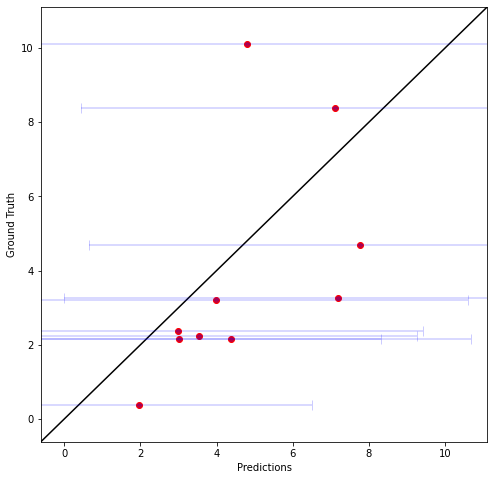

In [37]:
# plot predictions
plt.figure(figsize=(8,8))
plt.scatter(y_pred_rescaled, test_bags.y, color="red")
plt.plot(np.linspace(-100,100,201), np.linspace(-100,100,201), color="black")

plt.errorbar(
    y_pred_rescaled[:,0],
    test_bags.y[:,0],
    xerr=errors,
    fmt="o",
    ls="none",
    capsize=5,
    markersize=4,
    color="blue",
    alpha=0.2
    )
plt.xlim((test_bags.y.min()-1, test_bags.y.max()+1))
plt.ylim((test_bags.y.min()-1, test_bags.y.max()+1))
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")

In [41]:
#  An example of load-then-predict

# reinstantiate the model
k = gpflow.kernels.RBF(active_dims=col_index_all)
m = VBagg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z,num_data=train_bags.num_bags)
gpflow.set_trainable(m.inducing_variable, False)

load_model(m, f"./VBagg_example.pickle")


In [42]:
# make predictions
y_pred = np.zeros(test_bags.num_bags)
y_std = np.zeros(test_bags.num_bags)

for i, bag in enumerate(test_bags.bags):
    f_mean, f_var = m.predict_aggregated(test_bags[bag][1], test_bags[bag][2])
    y_pred[i] = f_mean[0][0]
    y_std[i] = np.sqrt(f_var[0][0])
    
loglik = np.mean(m.predict_log_density(y_pred[:, None], y_std[:, None]**2, scaler_y.transform(test_bags.y)))
y_pred_rescaled = scaler_y.inverse_transform(y_pred[:, None])

In [43]:
# calculate 95% credible intervals
lower = np.reshape((1.96 * y_std)*scaler_y.scale_, y_test.shape)
upper = np.reshape((1.96 * y_std)*scaler_y.scale_, y_test.shape)
errors = np.concatenate((lower, upper), axis=1)
errors = errors.T

# compute metrics 
loglik = np.mean(m.predict_log_density(y_pred[:, None], y_std[:, None]**2, scaler_y.transform(test_bags.y)))
RMSE = np.sqrt(np.mean((y_pred_rescaled - test_bags.y)**2))

print(f"Predictions: RMSE {loglik}, RMSE {RMSE}")

Predictions: RMSE -0.8267836204186395, RMSE 2.558671954345382


Text(0, 0.5, 'Ground Truth')

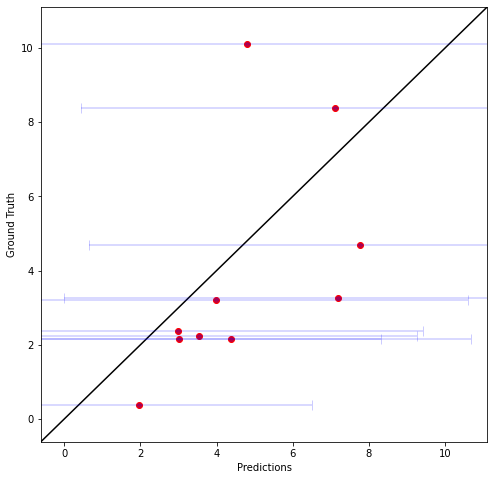

In [44]:
# plot predictions
plt.figure(figsize=(8,8))
plt.scatter(y_pred_rescaled, test_bags.y, color="red")
plt.plot(np.linspace(-100,100,201), np.linspace(-100,100,201), color="black")

plt.errorbar(
    y_pred_rescaled[:,0],
    test_bags.y[:,0],
    xerr=errors,
    fmt="o",
    ls="none",
    capsize=5,
    markersize=4,
    color="blue",
    alpha=0.2
    )
plt.xlim((test_bags.y.min()-1, test_bags.y.max()+1))
plt.ylim((test_bags.y.min()-1, test_bags.y.max()+1))
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")